<a href="https://colab.research.google.com/github/qaws2577849/siamese_TeaProject/blob/main/%E3%80%8CSiamese_raw_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper functions

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Configuration Class

In [ ]:
class Config():
    training_dir = "/content/drive/MyDrive/siamese_1/training_set/"
    testing_dir = "/content/drive/MyDrive/siamese_1/testing_set/"
    train_batch_size = 32
    train_number_epochs = 4

# Custom Dataset Class

In [ ]:
import random
from PIL import Image
import PIL.ImageOps
import torch
import numpy as np

class SiameseNetworkDataset(Dataset):

    def __init__(self, imageFolderDataset, transform=None, should_invert=False, crop_size=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert
        self.crop_size = 700

    def center_crop(self, image):
        if self.crop_size is not None:
            width, height = image.size
            left = (width - self.crop_size) // 2
            top = (height - self.crop_size) // 2
            right = (width + self.crop_size) // 2
            bottom = (height + self.crop_size) // 2
            image = image.crop((left, top, right, bottom))
        return image

    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # 中心裁切图像
        img0 = self.center_crop(img0)
        img1 = self.center_crop(img1)

        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)


# Using Image Folder Dataset

In [ ]:
Config = Config();
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

# Visualising some of the data

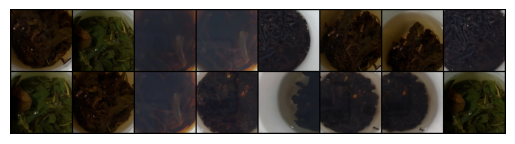

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter) #長度為3
concatenated = torch.cat((example_batch[0],example_batch[1]),0) #[16,1,100,100]
#print(concatenated)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())


# Neural Net Definition

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout(0.3),

            nn.ReflectionPad2d(3),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout(0.2),

            nn.ReflectionPad2d(3),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(100352, 5000),
            nn.ReLU(inplace=True),

            nn.Linear(5000, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2



# Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        nn.Flatten(output1,1)
        nn.Flatten(output2,1)
        loss = nn.BCEWithLogitsLoss()

        pred_sig = F.pairwise_distance(output1, output2, keepdim = True)
        #nn.Sigmoid()(pred_sig)
        return loss(pred_sig, label)

# Training Time!

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=Config.train_batch_size)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = []
iteration_number= 0

Epoch number 0
 Current loss 0.6914987564086914

Epoch number 0
 Current loss 1.256024956703186

Epoch number 0
 Current loss 0.8014661073684692

Epoch number 0
 Current loss 0.5254793763160706

Epoch number 0
 Current loss 0.5577809810638428

Epoch number 0
 Current loss 0.4485025405883789

Epoch number 0
 Current loss 0.5144467353820801

Epoch number 0
 Current loss 0.5086183547973633

Epoch number 0
 Current loss 0.5325678586959839

Epoch number 0
 Current loss 0.5193209052085876

Epoch number 0
 Current loss 0.5600826144218445

Epoch number 0
 Current loss 0.4392816424369812

Epoch number 0
 Current loss 0.44417643547058105

Epoch number 0
 Current loss 0.5809091925621033

Epoch number 0
 Current loss 0.4996258318424225

Epoch number 0
 Current loss 0.5222554206848145

Epoch number 0
 Current loss 0.5455684661865234

Epoch number 0
 Current loss 0.5526093244552612

Epoch number 0
 Current loss 0.5409920811653137

Epoch number 0
 Current loss 0.5482116937637329

Epoch number 0
 Curr

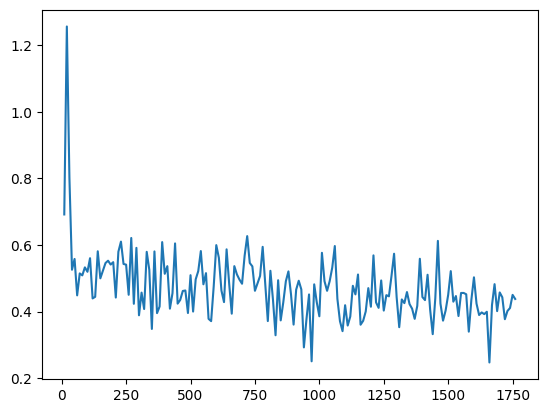

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

# Some simple testing

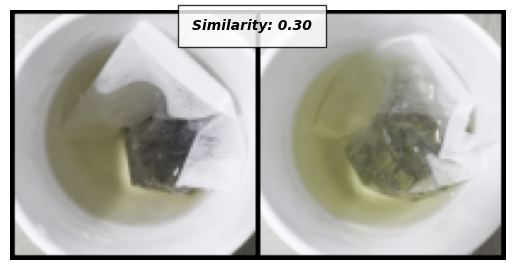

兩者類別是否相同:不相同


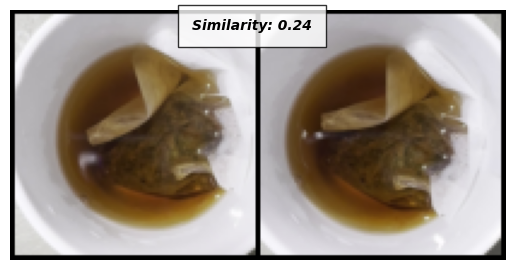

兩者類別是否相同:相同


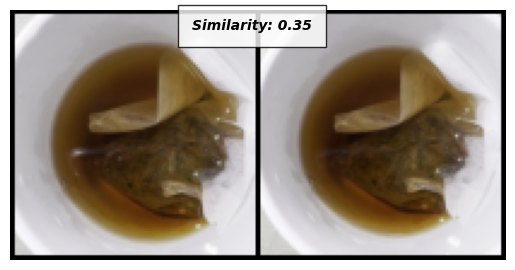

兩者類別是否相同:相同


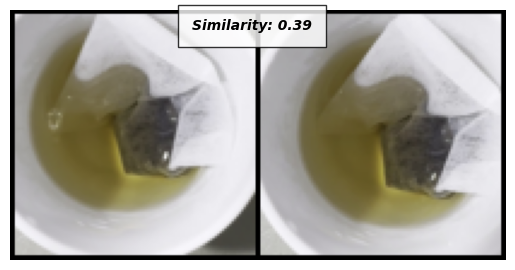

兩者類別是否相同:相同


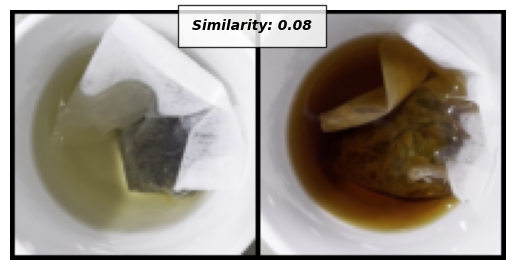

兩者類別是否相同:不相同


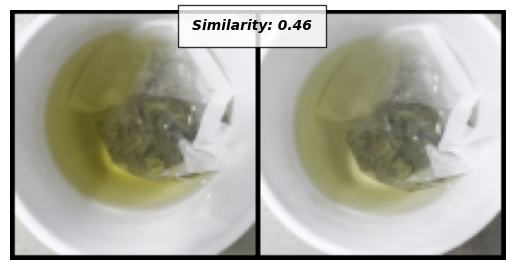

兩者類別是否相同:不相同


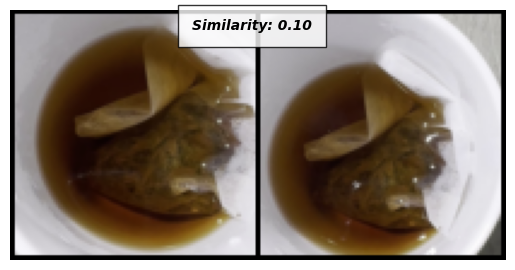

兩者類別是否相同:相同


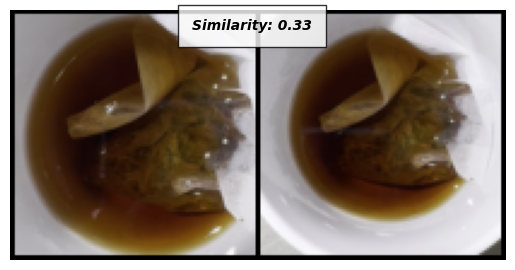

兩者類別是否相同:相同


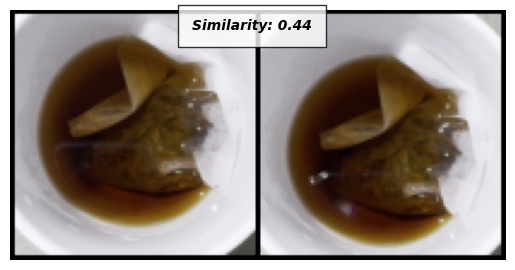

兩者類別是否相同:相同


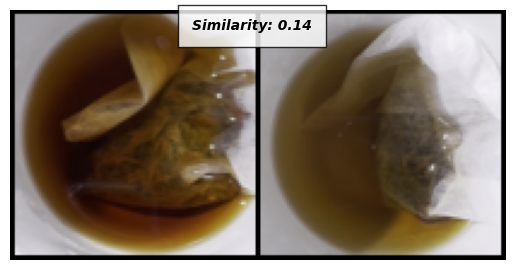

兩者類別是否相同:不相同


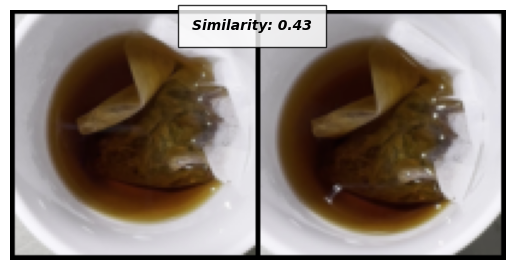

兩者類別是否相同:相同


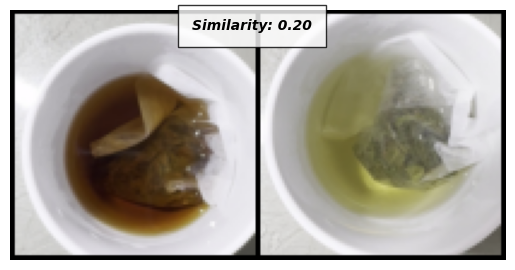

兩者類別是否相同:不相同


In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size= 1,shuffle=True)
for i in range(12):
    dataiter = iter(test_dataloader)
    batch = next(dataiter)
    concat = torch.cat((batch[0],batch[1]),0)
    #x0 = torch.cat(batch[0],0) #[16,1,100,100]
    #x1 = torch.cat(batch[1],0) #[16,1,100,100]
    output1,output2 = net(Variable(batch[0]).cuda(),Variable(batch[1]).cuda())
    nn.Flatten(output1,1)
    nn.Flatten(output2,1)
    euclidean_distance = F.pairwise_distance(output1, output2)

    imshow(torchvision.utils.make_grid(concat),'Similarity: {:.2f}'.format( abs(1-(nn.Sigmoid()(euclidean_distance).item()))))

    same =""
    if(batch[2].numpy()==1):
        same ="不相同"
    else:
        same ="相同"
    print('兩者類別是否相同:{0}'.format(same))


# test accuracy

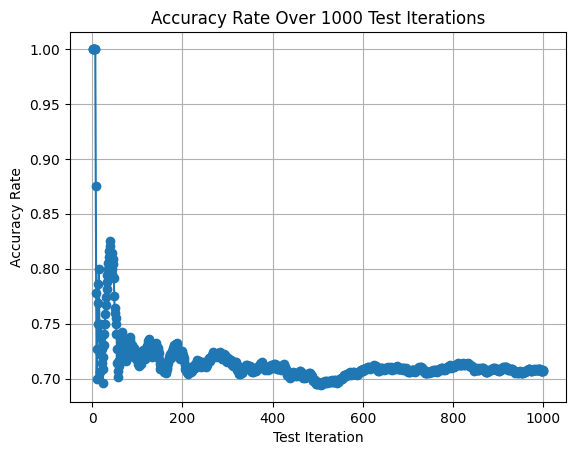

Final accuracy: 0.707


In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)

true=0
false=0
accuracy_rates = []
for i in range(1000):
    dataiter = iter(test_dataloader)
    batch = next(dataiter)

    output1,output2 = net(batch[0].cuda(),batch[1].cuda())
    nn.Flatten(output1,1)
    nn.Flatten(output2,1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    acc = round(abs(1-(nn.Sigmoid()(euclidean_distance).item())),2)
    if acc >= 0.3 and batch[2].numpy()==0:
            true += 1
    elif acc >= 0.3 and batch[2].numpy()==1:
            false += 1
    elif acc < 0.3 and batch[2].numpy()==0:
            false += 1
    elif acc < 0.3 and batch[2].numpy()==1:
            true += 1
    accuracy_rate = true / (true + false)
    accuracy_rates.append(accuracy_rate)

plt.plot(range(1, 1001), accuracy_rates, marker='o', linestyle='-')
plt.xlabel('Test Iteration')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy Rate Over 1000 Test Iterations')
plt.grid(True)
plt.show()

print("Final accuracy:", accuracy_rate)

 Sava model and load

In [ ]:
#SAVE
path = "/content/drive/MyDrive/cnn/model_5.pt"
torch.save(net.state_dict(), path)

In [ ]:
#LOAD
path = "/content/drive/MyDrive/cnn/model_5.pt"
model = SiameseNetwork()
model.load_state_dict(torch.load(path))
model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): ReflectionPad2d((3, 3, 3, 3))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReflectionPad2d((3, 3, 3, 3))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=100352, out_features=5000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=5000, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, o

In [ ]:
# import joblib
# joblib.dump(net,"modle_1")


['modle_1']

# Predict

In [ ]:
import os, random, shutil
import matplotlib.image as img # img 用于读取图片
from PIL import Image
import tensorflow as tf
import cv2
import torch

In [ ]:
#predict_dataloader = DataLoader("/content/drive/MyDrive/張",batch_size=1,shuffle=True)
#dataiter = iter(predict_dataloader)
model = model.cuda()

In [ ]:
def center_crop(img, new_size):
    width, height = img.size
    left = (width - new_size) // 2
    top = (height - new_size) // 2
    right = (width + new_size) // 2
    bottom = (height + new_size) // 2
    return img.crop((left, top, right, bottom))



In [ ]:
#迴圈比較
pathDir = os.listdir("/content/drive/MyDrive/siamese_1/testing_set/寒舍包種_C/") #比較類別
rand = random.sample(pathDir,1)
x1 = Image.open("/content/drive/MyDrive/siamese_1/testing_set/寒舍包種_C/"+ rand[0])  #比較類別
x0 = Image.open("/content/drive/MyDrive/IMG_7016.jpg") #輸入照片的路徑
center_crop(x0)
center_crop(x1)
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])
x0 = transform(x0)  # Transform x0 to a PyTorch tensor
x1 = transform(x1)

x0 = x0.unsqueeze(0)
x1 = x1.unsqueeze(0)


output1,output2 = model(x0.cuda(),x1.cuda())

nn.Flatten(output1,1)
nn.Flatten(output2,1)
euclidean_distance = F.pairwise_distance(output1, output2)

acc_a = round(abs(1-(nn.Sigmoid()(euclidean_distance).item())),2)

print(acc_a)

0.01


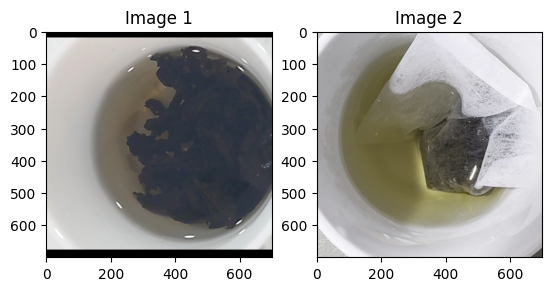

0.12


In [ ]:
pathDir = os.listdir("/content/drive/MyDrive/siamese_1/testing_set/張協興鐵觀音_B/") #比較類別
rand = random.sample(pathDir,1)
x1 = Image.open("/content/drive/MyDrive/siamese_1/testing_set/張協興鐵觀音_B/"+ rand[0])  #比較類別
x0 = Image.open("/content/drive/MyDrive/張鐵觀音") #輸入照片的路徑

new_size = 700

x0 = center_crop(x0,new_size)
x1 = center_crop(x1,new_size)

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])
x0 = transform(x0)  # Transform x0 to a PyTorch tensor
x1 = transform(x1)

x0 = x0.unsqueeze(0)
x1 = x1.unsqueeze(0)


output1,output2 = model(x0.cuda(),x1.cuda())

nn.Flatten(output1,1)
nn.Flatten(output2,1)
euclidean_distance = F.pairwise_distance(output1, output2)

acc_b = round(abs(1-(nn.Sigmoid()(euclidean_distance).item())),2)

print(acc_b)

In [ ]:
pathDir = os.listdir("/content/drive/MyDrive/siamese_1/testing_set/張協興包種_C/") #比較類別
rand = random.sample(pathDir,1)
x1 = Image.open("/content/drive/MyDrive/siamese_1/testing_set/張協興包種_C/"+ rand[0])  #比較類別
x0 = Image.open("/content/drive/MyDrive/張.jpg") #輸入照片的路徑
center_crop(x0)
center_crop(x1)
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])
x0 = transform(x0)  # Transform x0 to a PyTorch tensor
x1 = transform(x1)

x0 = x0.unsqueeze(0)
x1 = x1.unsqueeze(0)


output1,output2 = model(x0.cuda(),x1.cuda())

nn.Flatten(output1,1)
nn.Flatten(output2,1)
euclidean_distance = F.pairwise_distance(output1, output2)

acc_c = round(abs(1-(nn.Sigmoid()(euclidean_distance).item())),2)

print(acc_c)

0.07


In [ ]:
max = 0
label = ""
if acc_a > max:
    max = acc_a
    label = "現在這個狀態味道清淡"
if acc_b > max:
    max = acc_b
    label = "現在這個狀態味道適中"
if acc_c > max:
    max = acc_c
    label = "現在這個狀態味道濃厚"
if max < 0.2:
    label = "很抱歉，圖片無法辨識，不符合任何類別"
    max = ""

print(label)


B 0.42
